<a href="https://colab.research.google.com/github/NastaCom/ML_for_business/blob/main/HW_6_Gorokhova_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Домашнее задание

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
3. сделать feature engineering
4. обучить любой классификатор (какой вам нравится)
5. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
6. применить random negative sampling для построения классификатора в новых условиях
7. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
8. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

https://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++

Аннотация : набор данных включает 244 экземпляра, которые перегруппировывают данные двух регионов Алжира.
    
Набор данных включает 244 экземпляра, которые перегруппировывают данные двух регионов Алжира, а именно региона Беджая, расположенного на северо-востоке Алжира, и региона Сиди-Бель-Аббес, расположенного на северо-западе Алжира.

122 экземпляра для каждого региона.

Период с июня 2012 г. по сентябрь 2012
г. Набор данных включает 11 атрибутов и 1 выходной атрибут (класс)
. 244 случая были классифицированы как «пожарные» (138 классов) и «не пожарные» (106 классов). классы.

Информация об атрибутах:

1. Дата: (ДД/ММ/ГГГГ) День, месяц (с июня по сентябрь), год (2012 г.)
Наблюдения за погодными данными
2. Температура: температура в полдень (максимальная температура) в градусах Цельсия: от 22 до 42
3. RH : Относительная влажность в %: от 21 до 90
4. Ws : Скорость ветра в км/ч: от 6 до 29
5. Дождь: общее количество дней в мм: от 0 до 16,8
Компоненты FWI
6. Индекс точного определения влажности топлива (FFMC) из Система FWI: от 28,6 до 92,5
7. Индекс кода влажности Даффа (DMC) из системы FWI: от 1,1 до 65,9
8. Индекс кода засухи (DC) из системы FWI: от 7 до 220,4
9. Индекс начального распространения (ISI) из Система FWI: от 0 до 18,5
10. Индекс индекса застройки (BUI) из системы FWI: от 1,1 до 68
11. Индекс индекса пожарной погоды (FWI): от 0 до 31,1
12. Классы: два класса, а именно «Огонь» и «Не огонь».

In [ ]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import catboost as catb

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score

In [ ]:
df = pd.read_csv('Algerian_forest_fires_dataset_UPDATE.csv', header=1)
df.head(5)

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
0,01,06,2012,29,57,18,0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
1,02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,not fire
2,03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
3,04,06,2012,25,89,13,2.5,28.6,1.3,6.9,0,1.7,0,not fire
4,05,06,2012,27,77,16,0,64.8,3,14.2,1.2,3.9,0.5,not fire


Необходимо подготовить полученный датасет в удобный для работы вид.

In [ ]:
df.columns

Index(['day', 'month', 'year', 'Temperature', ' RH', ' Ws', 'Rain ', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes  '],
      dtype='object')

In [ ]:
df = df.rename(columns = {'Classes  ': 'Classes'} )

In [ ]:
df.shape

(246, 14)

In [ ]:
df.drop(columns='day',axis=1,inplace=True)
df.drop(columns='month',axis=1,inplace=True)
df.drop(columns='year',axis=1,inplace=True)
df.head()

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
0,29,57,18,0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
1,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,not fire
2,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
3,25,89,13,2.5,28.6,1.3,6.9,0,1.7,0,not fire
4,27,77,16,0,64.8,3,14.2,1.2,3.9,0.5,not fire


In [ ]:
df = df[df['Classes'].notna()]
df

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
0,29,57,18,0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
1,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,not fire
2,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
3,25,89,13,2.5,28.6,1.3,6.9,0,1.7,0,not fire
4,27,77,16,0,64.8,3,14.2,1.2,3.9,0.5,not fire
...,...,...,...,...,...,...,...,...,...,...,...
241,30,65,14,0,85.4,16,44.5,4.5,16.9,6.5,fire
242,28,87,15,4.4,41.1,6.5,8,0.1,6.2,0,not fire
243,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2,not fire
244,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,not fire


In [ ]:
uniqueValues = df['Classes'].unique()
print('уникальные значения в "Classes" ')
print(uniqueValues)

уникальные значения в "Classes" 
['not fire   ' 'fire   ' 'fire' 'fire ' 'not fire' 'not fire ' 'Classes  '
 'not fire     ' 'not fire    ']


In [ ]:
df['Classes'] = df['Classes'].str.replace('not fire   ', 'not fire')
df['Classes'] = df['Classes'].str.replace('not fire ', 'not fire')
df['Classes'] = df['Classes'].str.replace('not fire     ', 'not fire')
df['Classes'] = df['Classes'].str.replace('not fire    ', 'not fire')
df['Classes'] = df['Classes'].str.replace('not fire ', 'not fire')

df['Classes'] = df['Classes'].str.replace('fire   ', 'fire')
df['Classes'] = df['Classes'].str.replace('fire ', 'fire')

df = df[df.Classes != "Classes  "]

In [ ]:
uniqueValues = df['Classes'].unique()
print('уникальные значения в "Classes" ')
print(uniqueValues)

уникальные значения в "Classes" 
['not fire' 'fire']


In [ ]:
from sklearn.preprocessing import LabelEncoder
df['Classes_enc']=LabelEncoder().fit_transform(df[['Classes']])
df

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
<ipython-input-138-efc5a33fc711>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Classes_enc']=LabelEncoder().fit_transform(df[['Classes']])


,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Classes_enc
0,29,57,18,0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,1
1,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,not fire,1
2,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,1
3,25,89,13,2.5,28.6,1.3,6.9,0,1.7,0,not fire,1
4,27,77,16,0,64.8,3,14.2,1.2,3.9,0.5,not fire,1
...,...,...,...,...,...,...,...,...,...,...,...,...
241,30,65,14,0,85.4,16,44.5,4.5,16.9,6.5,fire,0
242,28,87,15,4.4,41.1,6.5,8,0.1,6.2,0,not fire,1
243,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2,not fire,1
244,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,not fire,1


In [ ]:
df.drop(columns='Classes',axis=1,inplace=True)
df

C:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes_enc
0,29,57,18,0,65.7,3.4,7.6,1.3,3.4,0.5,1
1,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,1
2,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,1
3,25,89,13,2.5,28.6,1.3,6.9,0,1.7,0,1
4,27,77,16,0,64.8,3,14.2,1.2,3.9,0.5,1
...,...,...,...,...,...,...,...,...,...,...,...
241,30,65,14,0,85.4,16,44.5,4.5,16.9,6.5,0
242,28,87,15,4.4,41.1,6.5,8,0.1,6.2,0,1
243,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2,1
244,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243 entries, 0 to 245
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Temperature  243 non-null    object
 1    RH          243 non-null    object
 2    Ws          243 non-null    object
 3   Rain         243 non-null    object
 4   FFMC         243 non-null    object
 5   DMC          243 non-null    object
 6   DC           243 non-null    object
 7   ISI          243 non-null    object
 8   BUI          243 non-null    object
 9   FWI          243 non-null    object
 10  Classes_enc  243 non-null    int32 
dtypes: int32(1), object(10)
memory usage: 21.8+ KB


In [ ]:
for column in df:
    if df[column].dtypes == np.object:
        df[column] = df[column].astype(str).astype(float)

df.dtypes

<ipython-input-141-973290f5e4aa>:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if df[column].dtypes == np.object:
<ipython-input-141-973290f5e4aa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].astype(str).astype(float)


Temperature    float64
 RH            float64
 Ws            float64
Rain           float64
FFMC           float64
DMC            float64
DC             float64
ISI            float64
BUI            float64
FWI            float64
Classes_enc      int32
dtype: object

In [ ]:
df.iloc[:, -1].value_counts(normalize=True)

0    0.563786
1    0.436214
Name: Classes_enc, dtype: float64

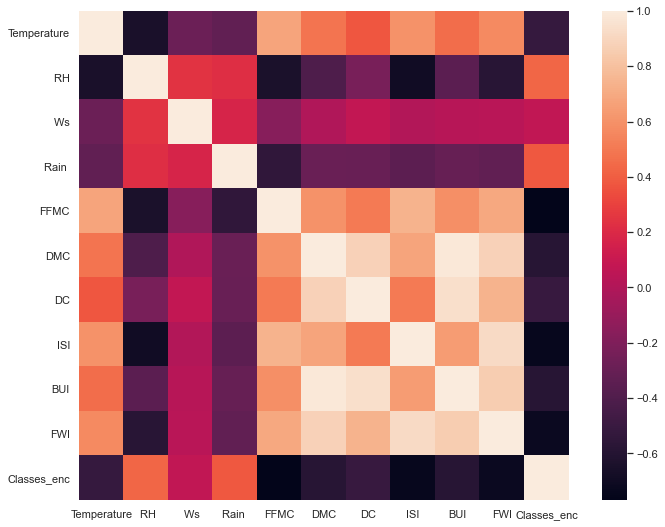

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1, square=True);

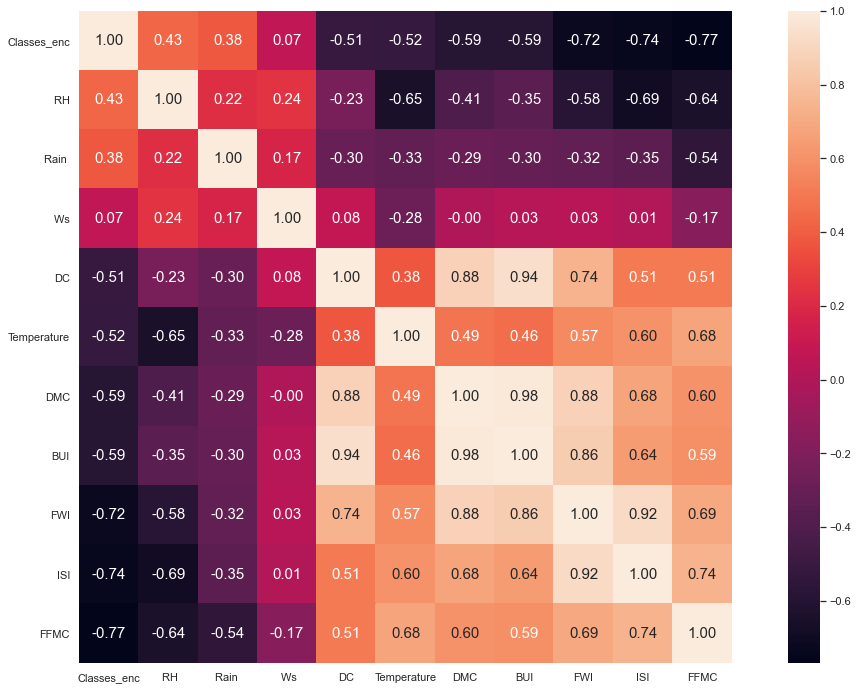

In [ ]:
k = len(df.columns)
cols = corrmat.nlargest(k, 'Classes_enc')['Classes_enc'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1)
f, ax = plt.subplots(figsize=(20, 12))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [ ]:
df.columns

Index(['Temperature', ' RH', ' Ws', 'Rain ', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI',
       'FWI', 'Classes_enc'],
      dtype='object')

In [ ]:
# удалю корреляцию ниже -0.6
df.drop('FFMC',axis=1,inplace=True)
df.drop('ISI',axis=1,inplace=True)
df.drop('FWI',axis=1,inplace=True)
df.head()

C:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Temperature,RH,Ws,Rain,DMC,DC,BUI,Classes_enc
0,29.0,57.0,18.0,0.0,3.4,7.6,3.4,1
1,29.0,61.0,13.0,1.3,4.1,7.6,3.9,1
2,26.0,82.0,22.0,13.1,2.5,7.1,2.7,1
3,25.0,89.0,13.0,2.5,1.3,6.9,1.7,1
4,27.0,77.0,16.0,0.0,3.0,14.2,3.9,1


Разбиваем выборку на тренировочную и тестовую части и обучаем модель (в примере - градиентный бустинг)

In [ ]:
from sklearn.model_selection import train_test_split

x_data = df.iloc[:,:-1]
y_data = df.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=7)

In [ ]:
import xgboost as xgb

model = xgb.XGBClassifier()

model.fit(x_train, y_train)
y_predict = model.predict(x_test)

[10:07:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Проверяем качество

In [ ]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score

def evaluate_results(y_test, y_predict, print_flag=True):
    f1 = f1_score(y_test, y_predict)
    roc = roc_auc_score(y_test, y_predict)
    rec = recall_score(y_test, y_predict, average='binary')
    prc = precision_score(y_test, y_predict, average='binary')
    
    if print_flag:
        print('Classification results:')
        print("f1: %.2f%%" % (f1 * 100.0))
        print("roc: %.2f%%" % (roc * 100.0))
        print("recall: %.2f%%" % (rec * 100.0))
        print("precision: %.2f%%" % (prc * 100.0))
    else:
        return [f1, roc, rec, prc]
    
metrics = []
evaluate_results(y_test, y_predict)
metrics.append(evaluate_results(y_test, y_predict, print_flag=False))

Classification results:
f1: 88.24%
roc: 92.33%
recall: 93.75%
precision: 83.33%


Теперь очередь за PU learning

Представим, что нам неизвестны негативы и часть позитивов

### 25%

In [ ]:
mod_data = df.copy()
#get the indices of the positives samples
pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]
#shuffle them
np.random.shuffle(pos_ind)
# leave just 25% of the positives marked
pos_sample_len = int(np.ceil(0.25 * len(pos_ind)))
print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
pos_sample = pos_ind[:pos_sample_len]

Using 27/106 as positives and unlabeling the rest


Создаем столбец для новой целевой переменной, где у нас два класса - P (1) и U (-1)

In [ ]:
mod_data['class_test'] = -1
mod_data.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_data.iloc[:,-1].value_counts())

target variable:
 -1    216
 1     27
Name: class_test, dtype: int64


In [ ]:
mod_data.head(5)

,Temperature,RH,Ws,Rain,DMC,DC,BUI,Classes_enc,class_test
0,29.0,57.0,18.0,0.0,3.4,7.6,3.4,1,-1
1,29.0,61.0,13.0,1.3,4.1,7.6,3.9,1,-1
2,26.0,82.0,22.0,13.1,2.5,7.1,2.7,1,1
3,25.0,89.0,13.0,2.5,1.3,6.9,1.7,1,-1
4,27.0,77.0,16.0,0.0,3.0,14.2,3.9,1,1


1. random negative sampling

In [ ]:
mod_data = mod_data.sample(frac=1)
neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
pos_sample = mod_data[mod_data['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(27, 9) (27, 9)


In [ ]:
model = xgb.XGBClassifier()

model.fit(sample_train.iloc[:,:-2].values, 
          sample_train.iloc[:,-2].values)
y_predict = model.predict(sample_test.iloc[:,:-2].values)
evaluate_results(sample_test.iloc[:,-2].values, y_predict)

metrics.append(evaluate_results(sample_test.iloc[:,-2], y_predict, print_flag=False))

[10:07:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification results:
f1: 83.12%
roc: 85.91%
recall: 84.21%
precision: 82.05%


C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


#### Попробую разные доли

### 15%

In [ ]:
mod_data = df.copy()
#get the indices of the positives samples
pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]
#shuffle them
np.random.shuffle(pos_ind)
# leave just 15% of the positives marked
pos_sample_len = int(np.ceil(0.15 * len(pos_ind)))
print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
pos_sample = pos_ind[:pos_sample_len]

Using 16/106 as positives and unlabeling the rest


In [ ]:
mod_data['class_test'] = -1
mod_data.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_data.iloc[:,-1].value_counts())

target variable:
 -1    227
 1     16
Name: class_test, dtype: int64


In [ ]:
x_data = mod_data.iloc[:,:-2].values # just the X 
y_labeled = mod_data.iloc[:,-1].values # new class (just the P & U)
y_positive = mod_data.iloc[:,-2].values # original class

In [ ]:
mod_data = mod_data.sample(frac=1)
neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
pos_sample = mod_data[mod_data['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(16, 9) (16, 9)


In [ ]:
model = xgb.XGBClassifier()

model.fit(sample_train.iloc[:,:-2].values, 
          sample_train.iloc[:,-2].values)
y_predict = model.predict(sample_test.iloc[:,:-2].values)
evaluate_results(sample_test.iloc[:,-2].values, y_predict)

metrics.append(evaluate_results(sample_test.iloc[:,-2], y_predict, print_flag=False))

[10:07:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification results:
f1: 83.33%
roc: 85.69%
recall: 96.59%
precision: 73.28%


C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


### 35%

In [ ]:
mod_data = df.copy()
#get the indices of the positives samples
pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]
#shuffle them
np.random.shuffle(pos_ind)
# leave just 15% of the positives marked
pos_sample_len = int(np.ceil(0.35 * len(pos_ind)))
print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
pos_sample = pos_ind[:pos_sample_len]

Using 38/106 as positives and unlabeling the rest


In [ ]:
mod_data['class_test'] = -1
mod_data.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_data.iloc[:,-1].value_counts())

target variable:
 -1    205
 1     38
Name: class_test, dtype: int64


In [ ]:
x_data = mod_data.iloc[:,:-2].values # just the X 
y_labeled = mod_data.iloc[:,-1].values # new class (just the P & U)
y_positive = mod_data.iloc[:,-2].values # original class

In [ ]:
mod_data = mod_data.sample(frac=1)
neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
pos_sample = mod_data[mod_data['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(38, 9) (38, 9)


In [ ]:
model = xgb.XGBClassifier()

model.fit(sample_train.iloc[:,:-2].values, 
          sample_train.iloc[:,-2].values)
y_predict = model.predict(sample_test.iloc[:,:-2].values)
evaluate_results(sample_test.iloc[:,-2].values, y_predict)

metrics.append(evaluate_results(sample_test.iloc[:,-2], y_predict, print_flag=False))

C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:08:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification results:
f1: 82.81%
roc: 86.84%
recall: 86.89%
precision: 79.10%


In [ ]:
metrics_comparison_df = pd.DataFrame(np.array(metrics),
                   columns=['fscore', 'roc_auc', 'recall', 'precision'],
                   index=['XGBClassifier', 'XGBClassifier + random negative sampling 25%', 
                          'XGBClassifier + random negative sampling 15%', 
                          'XGBClassifier + random negative sampling 35%'])
metrics_comparison_df

,fscore,roc_auc,recall,precision
XGBClassifier,0.882353,0.923295,0.937500,0.833333
XGBClassifier + random negative sampling 25%,0.831169,0.859106,0.842105,0.820513
XGBClassifier + random negative sampling 15%,0.833333,0.856938,0.965909,0.732759
XGBClassifier + random negative sampling 35%,0.828125,0.868388,0.868852,0.791045


#### Размер выборки немного влияет на качество, в данном случае лучше всего получиласть модель со случайной выборкой 15%

Бонусный вопрос:

Как вы думаете, какой из методов на практике является более предпочтительным: random negative sampling или 2-step approach?

Думаю 2-step approach, т.к. он более устойчив за счет отсутствия случайности. Например, для random negative sampling может попасться неудачная с выборка